In [1]:
import os
import re
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification
from sklearn.metrics import confusion_matrix
from collections import Counter
from torch.optim import AdamW


readme：

This model is the ViT model, which is a neural network model for computer vision classification that utilizes transformers.
The following are the main module contents of this ipynb:

1.Confusion Matrix Function:
This section has written a confusion matrix to more intuitively view the distribution of training results, with the vertical axis being the answer and the horizontal axis being the prediction.

2.Get Dataset:
This part has obtained all the preprocessed data needed, acquired through our address on GitHub.
The data is divided into three categories: training, validation, and testing.

3.Train And Val Part:
Download the pretrained ViT model, assign weights, and begin training. After each training session, a confusion matrix for the validation set is obtained.

4.Testing Part:
This part will use the already trained model to conduct testing and observe the effects."

# Confusion Matrix Function

In [2]:
# Distribution visualization
def confusionBox(y_true, y_pred):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Draw the heatmap
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Annotate the numbers
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('ans')
    plt.xlabel('per')
    plt.xticks(np.arange(len(np.unique(y_true))))
    plt.yticks(np.arange(len(np.unique(y_true))))
    plt.tight_layout()
    plt.show()

def confusionBoxPer(y_true, y_pred):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Convert the confusion matrix to percentage form
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Draw the heatmap
    plt.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Percentage)')
    plt.colorbar()

    # Annotate the percentages
    thresh = cm_percentage.max() / 2.
    for i, j in itertools.product(range(cm_percentage.shape[0]), range(cm_percentage.shape[1])):
        plt.text(j, i, "{:0.1f}%".format(cm_percentage[i, j]),
                 horizontalalignment="center",
                 color="white" if cm_percentage[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(np.arange(len(np.unique(y_true))))
    plt.yticks(np.arange(len(np.unique(y_true))))
    plt.tight_layout()
    plt.show()


# Get Dataset

In [3]:

# Data transformation chain
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load datasets

dataset_train = datasets.ImageFolder('devide3.0/train', transform=transform)
dataset_val = datasets.ImageFolder('devide3.0/validate', transform=transform)
dataset_test = datasets.ImageFolder('devide3.0/test', transform=transform)

# Display data
print('dataset_train_len:', len(dataset_train))
print('dataset_val_len:', len(dataset_val))
print('dataset_test_len:', len(dataset_test))

# Labels
print('\n----dataset_train_classes labels:----')
for i in dataset_train.class_to_idx.keys():
    num, kind = i.split('_')
    num = round(float(num), 2)
    print(f"{num*100}% and {kind}:\t{dataset_train.class_to_idx[i]}")
print()
# Number of samples per label

# Use Counter to calculate the number of samples for each class
print('----dataset_train_classes samples:----')
counter_train = Counter(dataset_train.targets)
counter_val = Counter(dataset_val.targets)
counter_test = Counter(dataset_test.targets)
print(counter_train)
print(counter_val)
print(counter_test)

# Create data loaders
train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=8)
test_loader = DataLoader(dataset_test, batch_size=8)


dataset_train_len: 4135
dataset_val_len: 259
dataset_test_len: 531

----dataset_train_classes labels:----
0.0% and mono:	0
0.0% and poly:	1
33.0% and mono:	2
33.0% and poly:	3
67.0% and mono:	4
67.0% and poly:	5
100.0% and mono:	6
100.0% and poly:	7

----dataset_train_classes samples:----
Counter({1: 644, 7: 503, 3: 502, 0: 501, 2: 501, 6: 501, 4: 495, 5: 488})
Counter({1: 92, 0: 58, 7: 40, 6: 31, 3: 17, 2: 11, 4: 5, 5: 5})
Counter({1: 184, 0: 119, 7: 81, 6: 63, 3: 37, 2: 25, 4: 12, 5: 10})


# Train And Val Part

In [4]:
latest_epoch = 0
# Load the pretrained model locally
try:
    # When loading the model, find the latest model file
    model_directory = '.'  # Assume the model is saved in the current directory
    model_files = os.listdir(model_directory)
    model_epochs = {}
    # Use a regular expression to match the model files and their corresponding epochs
    pattern = re.compile(r'ViT_epoch_(\d+)')
    for filename in model_files:
        match = pattern.match(filename)
        if match:
            epoch_number = int(match.group(1))
            model_epochs[epoch_number] = filename
    # Find the largest epoch number, which is the latest model
    latest_epoch = max(model_epochs.keys())
    latest_model_path = model_epochs[latest_epoch]
    # Now you can load the latest model
    print('Local model loaded successfully')
    print(f'Model loaded from {latest_model_path}, which is from epoch {latest_epoch}')
    model = ViTForImageClassification.from_pretrained(latest_model_path, num_labels=len(dataset_train.classes))
    
except:
    print('Local model loading failed')
    print('Loading model from Web')
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=len(dataset_train.classes))
    
    
# If you have a GPU available, move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Training loop
# You can modify here to increase the number of training iterations.  
epochs = 3
for epoch in range(epochs):

    # Confusion matrix
    if (epoch+1) == epochs:
        output_box = []
        label_box = []

    model.train()
    for batch in train_loader:
        images, labels = batch
        # Duplicate channels to match the expected input of the model
        images = images.repeat(1, 3, 1, 1)
        images, labels = images.to(device), labels.to(device)

        # Forward propagation
        outputs = model(images).logits
        loss = loss_fn(outputs, labels)

        # Backward propagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs} finished.")

    # Validation loop
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch
            images = images.repeat(1, 3, 1, 1)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits

            _, predicted = torch.max(outputs.data, 1)
            # Record for confusion matrix
            if (epoch+1) == epochs:
                output_box += predicted.tolist()
                label_box += labels.tolist()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation accuracy: {100 * correct // total}%')

    # Plotting
    if (epoch+1) == epochs:
        confusionBox(label_box, output_box)
        confusionBoxPer(label_box, output_box)


# Save the model
model_save_path = f'ViT_epoch_{epochs + latest_epoch}'
model.save_pretrained(model_save_path)
print(f'Model saved to {model_save_path}')


Local model loaded successfully
Model loaded from ViT_epoch_12, which is from epoch 12
Epoch 1/3 finished.
Validation accuracy: 76%
Epoch 2/3 finished.
Validation accuracy: 78%


# Testing Part

Test accuracy: 77.97%


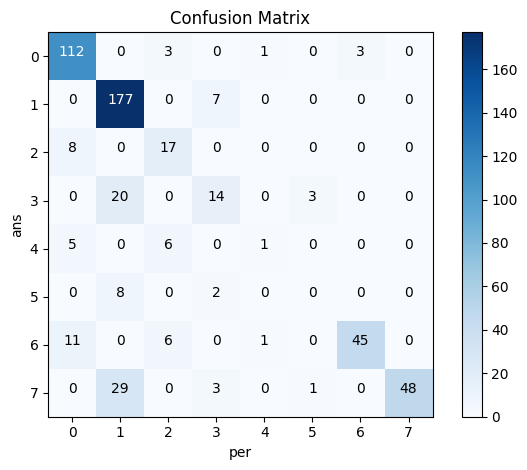

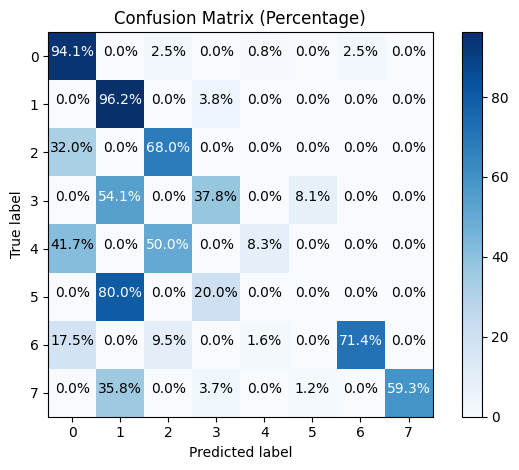

In [ ]:
output_box = []
label_box = []
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to track accuracy
total = 0
correct = 0

# Do not compute gradients, as they are not needed during testing
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        # Duplicate channels to match the expected input of the model
        images = images.repeat(1, 3, 1, 1)
        images, labels = images.to(device), labels.to(device)

        # Forward propagation
        outputs = model(images).logits

        # Save outputs and labels for the confusion matrix
        output_box += torch.max(outputs, dim=1)[1].tolist()
        label_box += labels.tolist()

        # Get the predictions
        _, predicted = torch.max(outputs.data, 1)

        # Update the total and the number of correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the total accuracy on the test set
accuracy = 100 * correct / total
print(f'Test accuracy: {accuracy:.2f}%')

# Plot the confusion matrix
confusionBox(label_box, output_box)
confusionBoxPer(label_box, output_box)
